# What is done?

#### 1. Upsampling with forward and backward fill method upto 1 second frequency
#### 2. Downsampling to 10 second frequency
#### 3. Outlier detection and replacement

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join as jp
from warnings import warn

from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from logparser import *

Load the data:

In [2]:
data_init = convert_folder('./log_dir/')
# sort by DATE
data_init = data_init.sort_values(by='DATE')
# delete microseconds
data_init['DATE'] = data_init['DATE'].map(lambda x: x.replace(microsecond=0))
# remove lines with Missing Values (NaNs)
data_init = data_init[~data_init.isnull().sum(axis=1).astype(bool).values].reset_index(drop=True).copy()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
22it [00:00, 3676.43it/s]
0it [00:00, ?it/s]
165it [00:00, 3307.53it/s]
0it [00:00, ?it/s]
3it [00:00, 29.20it/s]t/s]
0it [00:00, ?it/s]
13it [00:00, 6517.57it/s]
0it [00:00, ?it/s]C:\Users\i344436\OneDrive - SAP SE\Git\eHome\logparser\logparser.py:49: UserWarning: Possibly missing value in 47 line of file `./log_dir/data-2018-12-14-21.log` 
  warn("Possibly missing value in %s line of file `%s` " % (i+1, fp))
C:\Users\i344436\OneDrive - SAP SE\Git\eHome\logparser\logparser.py:49: UserWarning: Possibly missing value in 181 line of file `./log_dir/data-2018-12-14-21.log` 
  warn("Possibly missing value in %s line of file `%s` " % (i+1, fp))

303it [00:00, 11252.35it/s]
0it [00:00, ?it/s]
6it [00:00, 28.87it/s]it/s]
0it [00:00, ?it/s]
115it [00:00, 12825.94it/s]
0it [00:00, ?it/s]
344it [00:00, 22974.80it/s]
0it [00:00, ?it/s]
343it [00:00, 18101.87it/s]
0it [00:00, ?it/s]
10it [00:00, 29.70it/s]t/s]
0it [00:00, ?it/s]
342it [00:00, 24494.59it/s]
0it

Upsample and downsample time-series:

In [3]:
ts_1s = pd.DataFrame({'DATE': pd.date_range(start=data_init['DATE'].min(),
                                            end=data_init['DATE'].max(),
                                            freq='1s')})

ts_10s = pd.DataFrame({'DATE': pd.date_range(start=data_init['DATE'].min(),
                                             end=data_init['DATE'].max(),
                                             freq='10s')})

In [4]:
data = pd.merge(ts_1s, data_init, how='left', on='DATE')
# forward fill to remove problem with 10s unmatching
data = data.ffill()
# downsample to 10s
data = pd.merge(ts_10s, data, how='left', on='DATE')

Detect outliers and replace them:

In [6]:
df = data.copy()
df = df[df['DATE'] >= '2018-12-16']
df['MODE'] = df['MODE'].map({'on': 1, 'off': 0})

In [7]:
def replace_outliers(dataframe, column, window=5, sensitivity=10):
    dataframe = dataframe.copy()
    ts_mean = dataframe[column].rolling(window).mean().bfill().ffill()
    dataframe[column] = dataframe[column].mask(np.abs(ts_mean - dataframe[column]) > sensitivity, np.nan)
    dataframe[column] = dataframe[column].ffill()
    return dataframe

In [8]:
# T_3 has several outlier -> need to be replaced
df = replace_outliers(df, 'T_3')

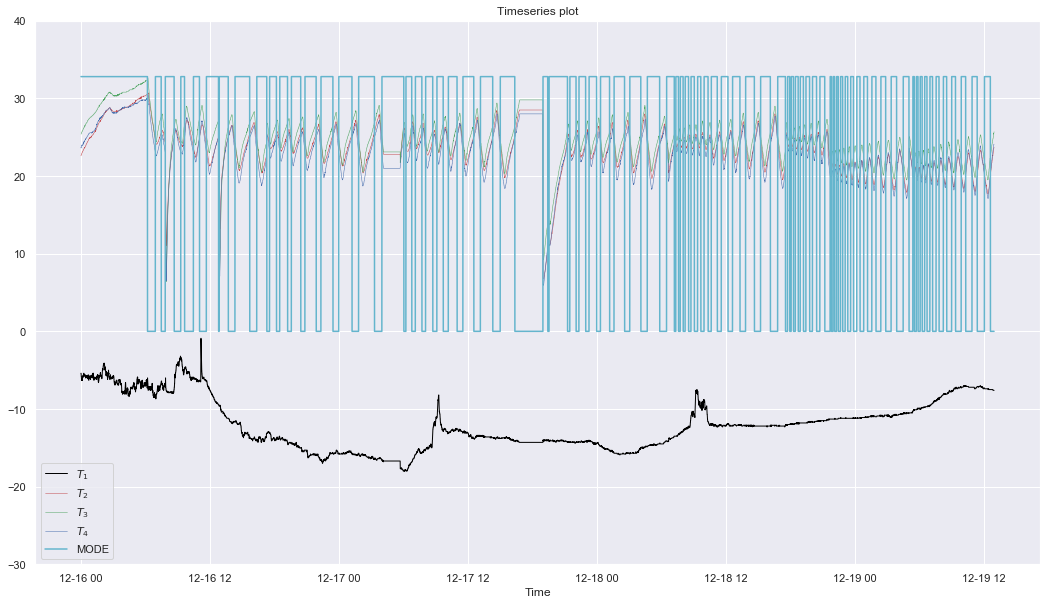

In [9]:
plt.figure(figsize=(18,10))
plt.title('Timeseries plot')
plt.plot(df['DATE'], df['T_1'], c='black', ls='-', lw=1, label='$T_1$')
plt.plot(df['DATE'], df['T_2'], 'r-', lw=0.5, label='$T_2$')
plt.plot(df['DATE'], df['T_3'], 'g-', lw=0.5, label='$T_3$')
plt.plot(df['DATE'], df['T_4'], 'b-', lw=0.5, label='$T_4$')
plt.plot(df['DATE'], df['MODE'] * df.max().values[1:].max(), 'c-', label='MODE')
plt.xlabel('Time')
plt.ylim((-30, 40))
plt.legend(loc='best')
plt.show()